## TFRecords

使用 Kaggle 上的 Dogs and Cats 来对 TFRecords 进行操作。

In [55]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

### 1. 下载数据文件

执行下面的命令，在下载之前请先 [Accept Rules](https://www.kaggle.com/c/dogs-vs-cats/rules)

```bash
kaggle competitions download -c dogs-vs-cats
```

默认会把数据文件下载到当前目录下。


### 2. 查看文件并且打标签

对下载的图片文件进行标注: cat (label = 0). dog(label = 1)。并且将数据集进行划分为: train(60%), validation(20%), test(20%).

In [69]:
import sys
import random
import glob

def prepare_data(path, shuffle=True):
    
    addrs = glob.glob(path + '/*.jpg')
    labels = [0 if 'cat' in addr else 1 for addr in addrs]
    
    if shuffle:
        c = list(zip(addrs, labels))
        random.shuffle(c)
        addrs, labels = zip(*c)
    
    # 将数据集分成三部分
    n_images = len(addrs)
    split_06 = int(0.6 * n_images)
    split_08 = int(0.8 * n_images)
    
    train_addrs = addrs[0:split_06]
    train_labels = labels[0:split_06]
    
    val_addrs = addrs[split_06:split_08]
    val_labels = labels[split_06:split_08]
    
    test_addrs = addrs[split_08:]
    test_labels = labels[split_08:]
    
    train = (train_addrs, train_labels)
    val = (val_addrs, val_labels)
    test = (test_addrs, test_labels)
    
    return train, val, test 

#### 2.2 图片文件数据提取

我们需要先用 OpenCV 对图片进行统一的转换，转换成 (224, 224) 的大小。

**注意**

- matplotlib.image 只能处理 png 文件
- cv2 读取的是 BGR 模式，matplotlib 是 RGB 模式。 BGR, RGB 的区别就是通道的顺序不同而已。
- jupyter 默认将启动目录作为 home 目录的，所以在指定系统的路径时，要指定绝对路径。

可以通过 `cv2.cvtColor(image, cv2.COLOR_BGR2RGB)` 进行转换。

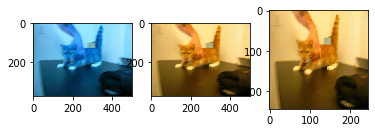

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = '/Users/eason/code/data/kaggle/01-dogs-and-cats/train/cat.0.jpg'
bgr_img = cv2.imread(img_path)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(rgb_img, (244, 244),
                         interpolation=cv2.INTER_CUBIC)

fig,axes = plt.subplots(1, 3)
axes[0].imshow(bgr_img) # OpenCV BGR 模式，不太对
axes[1].imshow(rgb_img) # 转换成 RGB 模式
axes[2].imshow(resized_img) # 统一 RESIZE

# plt.imshow(img)
plt.show()



处理图片时，我们可能需要对所有的图片进行统一的 resize。在进行 Resize 时 OpenCV 有以下四个 `interpolation` 选项, 即如何计算插值：

- `INTER_NN` : 默认类型，NN, Nearest Neighbors, 速度快。失真大些。
- `INTER_LINEAR`: 线型，速度相对较快，也会有失真。
- `INTER_AREA`: 抽样。
- `INTER_CUBIC`: a bicubic interpolation over 4x4 pixel neighborhood。推荐使用这一个。




In [58]:
def load_image(addr):
    # read an image and resize to (224, 224)
    img = cv2.imread(addr)
    img = cv2.resize(img,(244, 244), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

### TFRecords

在我们将数据存储到 TFRecords 文件之前，我们将数据填充到一个定义好的协议缓冲区内 (protocol buffer), 我们称之为 **Example**, 然后才将该字符串序列化一个字符串然后写入到 TFRecords 文件中。

Example Protocol Buffer 由 Features 组成。Feature 用来描述数据，数据有三种类型:bytes, float, int64。

总结如下：为了存储数据，我们需要下面这些步骤：

1. 使用 `tf.python.io.TFRecordWriter` 打开一个 TFRecords 文件。
2. 将数据转换成 `tf.train.Int64List, tf.train.FloatLit，tf.train.BytesList` feature。
3. 将数据传入 `tf.train.Feature` 中
4. 创建 `tf.train.Example`
5. 序列化 `example.SerializeToString()`
6. 将序列化的数据写入到文件 `writer.write()`


In [64]:
# 将数据转换成 features
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [74]:
# 将数据存储到 TFRecords 文件中

path = '/Users/eason/code/data/kaggle/01-dogs-and-cats/train'

train_filename = 'train.tfrecords'

writer = tf.python_io.TFRecordWriter(train_filename)

train, _, _ = prepare_data(path)
train_addrs, train_labels = train
n_addrs = len(train_addrs)

for i in range(n_addrs):
    # print how many images are saved every 1000 images
    if not i % 1000:
        print('Train Data: %d/%d' % (i, n_addrs))
        sys.stdout.flush()
    
    img = load_image(train_addrs[i])
    label = train_labels[i]
    
    # create a feature
    feature = {
        'train/label': _int64_feature(label),
        'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))
    }
    
    # create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())

writer.close()
sys.stdout.flush()
print('Save Completed!')

Train Data: 0/15000
Train Data: 1000/15000
Train Data: 2000/15000
Train Data: 3000/15000
Train Data: 4000/15000
Train Data: 5000/15000
Train Data: 6000/15000
Train Data: 7000/15000
Train Data: 8000/15000
Train Data: 9000/15000
Train Data: 10000/15000
Train Data: 11000/15000
Train Data: 12000/15000
Train Data: 13000/15000
Train Data: 14000/15000
Save Completed!


In [77]:
ls -lh

total 20938480
-rw-r--r--  1 eason  staff    64K Aug  4 19:25 01-TFRecords-dogs-and-cats.ipynb
-rw-r--r--  1 eason  staff    10G Aug  4 19:23 train.tfrecords


只是这生成的数据也太大了吧。**10GB**